In [1]:
import pyart
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import xarray as xr
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [3]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        # Make sure we are interpolating from the radar's location above sea level
        #da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(radar.altitude['data'][0], 10100, 100))
        da = pyart.util.columnsect.get_field_location(radar, lat, lon)
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Expand dimensions
        da = da.expand_dims("time")
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["units"].split(' ')[-1][:-1])
        da["time"] = [dt]
        # Make sure there are no duplicate height indices
        index = np.unique(da['height'], return_index=True)
        da = da.isel(height=index[1])
        # Append to the xrray dataset list. Interpolate heightsI'm so 
        column_list.append(da.interp(height=np.arange(100, 3000, 100)))
    # Concatenate the extracted radar columns for this scan across all sites    
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites

    return ds

In [4]:
def match_datasets(column, ground, site, DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations
    
    Parameters
    ----------
    column : Xarray DataSet
             Xarray DataSet containing the extracted radar column above multiple locations.
             Dimensions should include Time, Height, Site
             
    ground : str 
             String containing the path of the ground instrumentation file that is desired
             to be included within the extracted radar column dataset
             
    site : str
           Location of the ground instrument. Should be included within the filename. 
             
    Returns
    -------
    ds : Xarray DataSet
         Xarray Dataset containing the time-synced in-situ ground observations with
         the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file
        grd_ds = xr.open_dataset(ground)

    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    matched = grd_ds.resample(time='5Min', closed='right').sum(keep_attrs=True).interp(time=column.time, method='linear') 
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
    
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(platform_id=matched.platform_id)
        matched[var].attrs.update(data_level=matched.data_level)
        matched[var].attrs.update(location_description=matched.location_description)
        matched[var].attrs.update(datastream=matched.datastream)
        matched[var].attrs.update(doi=matched.doi)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
       
    return column 

In [5]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + np.arctan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)

In [6]:
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [7]:
def KHGX_mosaic(nradar, column):
    """
    KHGX and Matched TRACER ground instrumentation (M1 site) Moasic Figure
    Moasic is nested list containing one main plot, with 4 side plots
    
    Parameters
    ----------
    radar : str
        Path to radar file wished to be displayed in 'Main' subplot
    column : Xarray DataSet
        Xarray DataSet containing extracted radar column matched
        with in-situ ground observations.
        
    Returns
    -------
    fig : matplotlib figure
        Matplotlib Mosaic figure
    """
    # Read in the radar file
    radar = pyart.io.read(nradar)
    
    # Extract the lowest sweep for PPI plot
    radar0 = radar.extract_sweeps([0])
    
    # Create the display object from radar file
    display = pyart.graph.RadarMapDisplay(radar0)
    
    # define max/min time from the extracted column
    time_max = column.time.data[-1]
    time_min = column.time.data[0]
    
    # define the radar time
    radar_time = pd.to_datetime(radar.time['units'].split(' ')[-1][:-1])

    # Define the lat/lon from sweep 0 for projection plotting
    lats, lons, alt = radar0.get_gate_lat_lon_alt(0)

    # Define reflecitivty data from sweep 0 to display 
    reflectivity = radar0.fields['reflectivity']['data']

    # Define Site Location
    site_lat = float(ds.latitude_of_location.split(' ')[0])
    site_lon = float(ds.longitude_of_location.split(' ')[0])

    ##date_form = DateFormatter("%H%M UTC %b %d %Y")
       
    #---------------------------------------------------
    # Define the GridSpec for Detailed Subplot Placement
    #---------------------------------------------------
    fig = plt.figure(figsize=(16, 8))

    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(4, 1, hspace=0.775)

    # update the extent of the subplot
    gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)

    #-------------------
    # Plot the KHGX PPI
    #-------------------
    ax1 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())
    ax1.add_feature(cfeature.STATES, 
                    edgecolor='black',
                    linewidth=2)
    ax1.add_feature(cfeature.COASTLINE,
                    edgecolor='black')

    # Plot our velocity field using pcolormesh with edgecolors argument
    mesh = ax1.pcolormesh(lons,
                          lats,
                          reflectivity,
                          vmin=-10,
                          vmax=60,
                          edgecolors='face',
                          cmap='pyart_HomeyerRainbow')

    # Set the graphing limits
    ax1.set_extent((-96.1, -94.1, 28.5, 30.5))

    # Configure our colorbar
    cbar = plt.colorbar(mesh)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Equivalent Reflectivity Factor [dBZ]', fontsize=16)

    # Add gridlines
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),
                       draw_labels=True,
                       linewidth=2, 
                       color='gray', 
                       alpha=0.5,
                       linestyle='--')

    # Make sure labels are only plotted on the left and bottom
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Increase the fontsize of our gridline labels
    gl.xlabel_style = {'fontsize':14}
    gl.ylabel_style = {'fontsize':14}

    # Add our scale bar
    add_scale_line(25.0, ax1, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=2,
                   fontsize=16,
                   fontweight='bold')

    # Add site of interest
    ax1.plot(site_lon, site_lat,
             color='black', linewidth=2, marker='o',
             transform=ccrs.PlateCarree(),
             label="TRACER M1 Site"
             )

    # Add a title to the PPI plot
    plt.title(f"KHGX 0.5 Degree \n {radar.time['units'][14:]} \n Equivalent Reflectivity Factor",
              fontsize=14)

    plt.legend(loc='upper right',
               fontsize=14)

    #--------------------------------------------
    # Side Plot A - Column Extract - Reflectivity
    #--------------------------------------------

    ax2 = fig.add_subplot(gs00[0])
    reflect = column.sel(site='M1').sel(time=slice(column.time.data[0],
                                                   radar_time)).reflectivity.plot(x='time',
                                                                                  ax=ax2, 
                                                                                  cmap='pyart_HomeyerRainbow',
                                                                                  add_colorbar=True,
                                                                                  vmin=-10,
                                                                                  vmax=50)

    ax2.set_xlabel(' ')
    ax2.set_ylabel('Height of \n Radar Beam \n [m]')
    ax2.set_title("Extracted KHGX Reflectivty Column Above M1 Site")
    ax2.set_xlim(time_min, time_max)

    #----------------------------------------
    # Side Plot B - Column Extract - Velocity
    #----------------------------------------
    ax3 = fig.add_subplot(gs00[1])
    column.sel(site='M1').sel(time=slice(column.time.data[0],
                                         radar_time)).velocity.plot(x='time', 
                                                                    ax=ax3, 
                                                                    add_colorbar=True,
                                                                    vmin=-10,
                                                                    vmax=10)
    ax3.set_ylabel('Height of \n Radar Beam \n [m]')
    ax3.set_xlabel(' ')
    ax3.set_title("Extracted KHGX Doppler Velocity Above M1 Site")
    ax3.set_xlim(time_min, time_max)

    #---------------------------------------
    # Side Plot C - Laser Disdrometer - PSD
    #---------------------------------------
    ax4 = fig.add_subplot(gs00[2])
    norm = colors.LogNorm(vmin=1, vmax=1000)

    psd = column.sel(site="M1").sel(time=slice(column.time.data[0],
                                               radar_time)).number_density_drops.plot(x='time', 
                                                                                      norm=norm, 
                                                                                      cmap='pyart_HomeyerRainbow',
                                                                                      add_colorbar=False,
                                                                                      ax=ax4)
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)
    #cbax = divider.append_axes("right", size="3%")
    cbax = fig.add_axes([0.89, 0.33, 0.007, 0.115])
    cbar2 = fig.colorbar(psd, orientation="vertical", cax=cbax)
    cbar2.set_label('Number Density \n Per Unit Volume \n [#/m3 /mm]')
    #ax4.sharex(axd['SideA'])
    ax4.set_title("Laser Disdrometer Number Density at M1 Site")
    ax4.set_ylabel("Particle Class \n Size Average \n [mm]")
    ax4.set_xlabel(" ")
    ax4.set_xlim(time_min, time_max)
    ax4.set_ylim(0, 10)

    #------------------------------------------------------
    # Side Plot D - Laser Disdrometer - Precipitation Rate
    #------------------------------------------------------
    ax5 = fig.add_subplot(gs00[3])
    column.sel(site="M1").sel(time=slice(column.time.data[0],
                                         radar_time)).precip_rate.plot(x='time', ax=ax5)

    ax5.set_title("Laser Disdrometer Precipitation Rate at M1 Site")
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Precipitation \n Intensity \n [mm/hr]")
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)
    #ax5.xaxis.set_major_formatter(date_form)
    ax5.set_xlim(time_min, time_max)

    return fig

## Grab all the Data (Locally Stored)

In [8]:
file_list = sorted(glob.glob("/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/*"))
file_list[:10]

['/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_000447_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_001132_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_001816_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_002500_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_003144_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_003920_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_004549_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_005218_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_005847_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_005847_V06_MDM']

In [9]:
ld_files = sorted(glob.glob("/Users/celsloaner/ARM/Observations/LD/TRACER/M1/houldM1.b1.20220812.000000.cdf"))

## Extract the Radar Column above the TRACER M1 site. 

In [10]:
%%time
lats = [29.62]
lons = [-95.059]
sites = ["M1"]

ds_list = []
for file in file_list[:]:
    if file[-3:] != "MDM":
        print(file)
        ds_list.append(subset_points(file, lats, lons, sites))

/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_000447_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_001132_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_001816_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_002500_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_003144_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_003920_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_004549_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_005218_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_005847_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_010516_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_011144_V06
/Users/celsloaner/ARM/Observations/NEXRAD/K

/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_104351_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_105038_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_105726_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_110414_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_111108_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_111822_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_112536_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_113251_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_114006_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_114720_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_115435_V06
/Users/celsloaner/ARM/Observations/NEXRAD/K

/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_214417_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_215117_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_215832_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_220546_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_221246_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_221934_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_222649_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_223348_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_224048_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_224748_V06
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/12/KHGX/KHGX20220812_225432_V06
/Users/celsloaner/ARM/Observations/NEXRAD/K

In [11]:
ds = xr.concat(ds_list, dim='time')

## Match the Extracted Column to the Ground Laser Disdrometer

In [12]:
for lfile in ld_files:
    ds = match_datasets(ds, lfile, "M1")

/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial1' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial2' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'furuno' loading failed:
The 'geopandas' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'gamic' loa

In [13]:
ds = ds.transpose("time", "height", "site", "particle_size", "raw_fall_velocity")

## Plot the Radar Loops

In [15]:
%%time
for file in file_list[1:]:
    if file[-3:] != "MDM":
        figB = KHGX_mosaic(file, ds)
        nout = 'OBrien_TRACER_Mosaic_' + file.split('/')[-1] +'.png'
        print(nout)
        figB.savefig(nout)
        plt.close(figB)

/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_001132_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_001816_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_002500_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_003144_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_003920_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_004549_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_005218_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_005847_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_010516_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_011144_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_011813_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_012442_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_013110_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_013740_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_014409_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_015039_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_015638_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_020306_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_020935_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_021549_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_022203_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_022802_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_023415_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_024039_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_024632_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_025246_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_025854_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_030455_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_031057_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_031659_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_032301_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_032903_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_033504_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_034106_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_034724_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_035344_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_040018_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_040641_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_041325_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_041954_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_042637_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_043325_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_044009_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_044708_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_045423_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_050122_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_050810_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_051525_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_052212_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_052911_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_053618_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_054324_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_055030_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_055717_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_060405_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_061120_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_061835_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_062549_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_063304_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_064010_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_064717_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_065432_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_070146_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_070901_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_071616_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_072331_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_073046_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_073801_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_074404_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_075002_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_075601_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_080200_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_080813_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_081441_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_082156_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_082824_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_083508_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_084301_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_084946_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_085630_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_090330_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_091029_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_091744_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_092458_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_093204_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_093919_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_094619_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_095333_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_100048_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_100736_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_101451_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_102206_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_102921_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_103636_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_104351_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_105038_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_105726_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_110414_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_111108_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_111822_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_112536_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_113251_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_114006_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_114720_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_115435_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_120150_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_120905_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_121620_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_122334_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_123049_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_123804_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_124518_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_125233_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_125948_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_130703_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_131418_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_132124_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_132831_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_133546_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_134300_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_135015_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_135730_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_140445_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_141159_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_141914_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_142629_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_143335_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_144050_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_144805_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_145520_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_150208_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_150922_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_151637_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_152352_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_153107_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_153822_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_154536_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_155251_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_160006_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_160713_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_161418_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_162102_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_162731_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_163345_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_163958_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_164736_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_165451_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_170145_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_170859_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_171559_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_172314_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_173029_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_173712_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_174358_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_175001_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_175603_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_180232_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_180849_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_181503_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_182147_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_182817_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_183445_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_184113_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_184748_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_185417_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_190052_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_190726_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_191347_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_192001_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_192621_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_193235_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_193848_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_194502_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_195122_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_195806_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_200504_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_201219_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_201934_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_202634_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_203349_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_204054_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_204801_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_205507_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_210214_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_210921_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_211620_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_212320_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_213018_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_213702_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_214417_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_215117_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_215832_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_220546_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_221246_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_221934_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_222649_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_223348_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_224048_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_224748_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_225432_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_230116_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_230800_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_231429_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_232114_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_232716_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_233344_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_233957_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_234610_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_235224_V06.png


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


OBrien_TRACER_Mosaic_KHGX20220812_235838_V06.png
CPU times: user 28min 39s, sys: 5min 5s, total: 33min 44s
Wall time: 32min 26s


/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


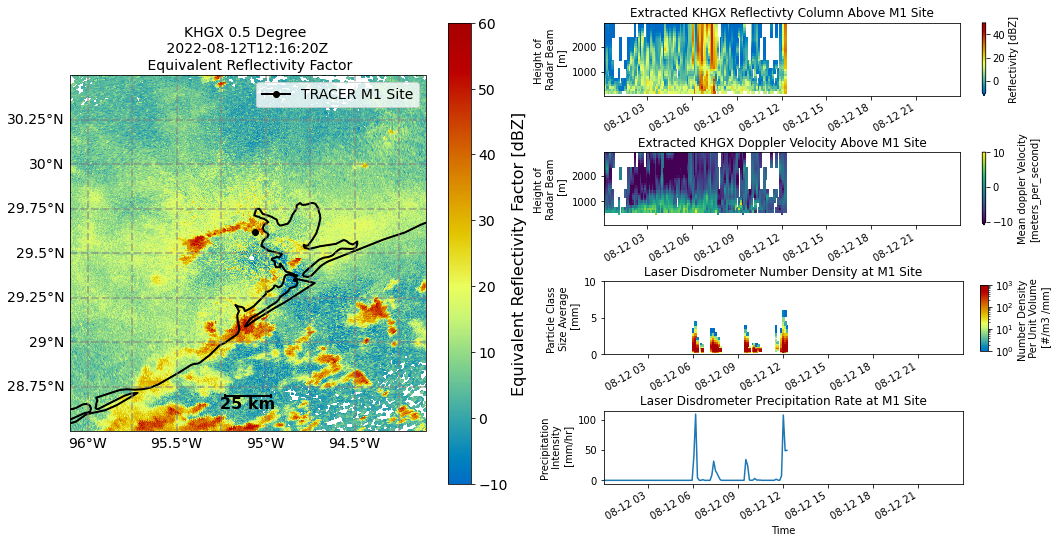

In [18]:
figC = KHGX_mosaic(file_list[120], ds)